In [9]:
from bs4 import BeautifulSoup     #网页解析，获取数据
import re       #正则表达式，进行文字匹配
import urllib.request,urllib.error  #指定URL，获取网页数据
import xlwt     #进行excel操作
import xlrd
import matplotlib.pyplot as plt

In [10]:
#影片详情链接的规则
findLink = re.compile(r'<a href="(.*?)">')     #创建正则表达式对象，表示影片详情链接的规则
#影片图片的规则
findImgSrc = re.compile(r'<img.*src="(.*?)"',re.S)    #re.S让换行符包含在字符中
#影片片名
findTitle = re.compile(r'<span class="title">(.*)</span>')
#影片评分
findRating = re.compile(r'<span class="rating_num" property="v:average">(.*)</span>')
#评价人数
findJudge = re.compile(r'<span>(\d*)人评价</span>')
#找到概况
findInq = re.compile(r'<span class="inq">(.*)</span>')
#找到影片的相关内容
findBd = re.compile(r'<p class="">(.*?)</p>',re.S)

In [11]:
#爬取网页
def getData(baseurl):
    datalist = []
    #调用获取页面信息的函数10次
    for i in range(0,10):
        url = baseurl + str(i*25)
        #保存获取到的网页源码
        html = askURL(url)
        # 2.逐一解析数据
        soup = BeautifulSoup(html,"html.parser")
        #找到符合要求的字符串，形成列表
        for item in soup.find_all('div',class_="item"):
            data = []    #保存一部电影的所有信息
            item = str(item)
            # print(item)
            # break

            # 影片详情的链接
            link = re.findall(findLink,item)[0]  #通过正则表达式查找指定的字符串
            data.append(link)   #添加链接

            imgSrc = re.findall(findImgSrc,item)[0]
            data.append(imgSrc) #添加图片

            titles = re.findall(findTitle,item)
            if(len(titles) == 2):
                ctitle = titles[0]
                data.append(ctitle) #添加中文名
                otitle = titles[1].replace("/","") #去掉无关的符号
                data.append(otitle) #添加外国名
            else:
                data.append(titles[0])
                data.append(' ') #外国名字留空

            rating = re.findall(findRating,item)[0]
            data.append(rating) #添加评分

            judgeNum = re.findall(findJudge,item)[0]
            data.append(judgeNum) #添加评价人数

            inq = re.findall(findInq,item)
            if len(inq) != 0:
                inq = inq[0].replace("。","") #去掉句号
                data.append(inq) #添加概述
            else:
                data.append(" ") #留空

            bd = re.findall(findBd,item)[0]
            bd = re.sub('<br(\s+)?/>(\s+)?'," ",bd) #去掉<br/>
            bd = re.sub('/'," ",bd) #去掉/
            data.append(bd.strip()) #去掉前后的空格

            datalist.append(data) #处理好的一部电影放入datalist
    print(datalist)
    return datalist

In [12]:
#得到指定一个URL的网页内容
def askURL(url):
    #用户代理，表示告诉豆瓣服务器，我们是什么类型的机器，浏览器（本质上是告诉浏览器，我们可以接收什么水平的文件内容）
    #模拟浏览器头部信息，向豆瓣服务器发送消息
    head = {"User-Agent": "Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Mobile Safari/537.36 Edg/87.0.664.66"}
    #创建请求对象
    request = urllib.request.Request(url,headers=head)
    html = ""
    try:
        #发送请求
        response = urllib.request.urlopen(request)
        #读取页面
        html = response.read().decode("utf-8")
        # print(html)
    except urllib.error.URLError as e:
        if hasattr(e,"code"):
            print(e.code)
        if hasattr(e,"reason"):
            print(e.reason)
    return html

In [13]:
#保存数据
def saveData(datalist,savepath):
    print("save...")
    book = xlwt.Workbook(encoding="utf-8",style_compression=0)  #创建workbook对象
    sheet = book.add_sheet('豆瓣电影Top250',cell_overwrite_ok=True) #创建工作表
    col = ("电影详情链接","图片链接","影片中文名","影片外国名","评分","评价数","概况","相关信息")
    for i in range(0,8):
        sheet.write(0,i,col[i]) #列名
    for i in range(0,250):
        print("第%d条"%(i+1))
        data = datalist[i]
        for j in range(0,8):
            sheet.write(i+1,j,data[j])  #数据
    book.save(savepath) #保存

In [14]:
# 可视化数据
def showData(savepath):

    # 这两行代码解决 plt 中文显示的问题
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    # 读取表格
    data = xlrd.open_workbook(savepath)
    # 获取表格的sheets
    table = data.sheets()[0]
    # 获取评分
    score = table.col_values(4)[1:]
    number = []
    number.append(score.count('8.3'))
    number.append(score.count('8.4'))
    number.append(score.count('8.5'))
    number.append(score.count('8.6'))
    number.append(score.count('8.7'))
    number.append(score.count('8.8'))
    number.append(score.count('8.9'))
    number.append(score.count('9.0'))
    number.append(score.count('9.1'))
    number.append(score.count('9.2'))
    number.append(score.count('9.3'))
    number.append(score.count('9.4'))
    number.append(score.count('9.5'))
    number.append(score.count('9.6'))
    number.append(score.count('9.7'))
    print(number)

    data = ['8.3','8.4','8.5','8.6','8.7','8.8','8.9','9.0','9.1','9.2','9.3','9.4','9.5','9.6','9.7']

    plt.bar(data, number)
    plt.xlabel('电影评分')
    plt.ylabel('电影数量')
    plt.title('电影评分分布表')

    plt.show()

In [15]:
def main():
    baseurl = "https://movie.douban.com/top250?start="
    #1.爬取网页
    datalist = getData(baseurl)
    savepath = "豆瓣电影Top250.xls"
    #3.保存数据
    saveData(datalist,savepath)
    # 可视化
    showData(savepath)

[['https://movie.douban.com/subject/1292052/', 'https://img2.doubanio.com/view/photo/s_ratio_poster/public/p480747492.jpg', '肖申克的救赎', '\xa0\xa0The Shawshank Redemption', '9.7', '2251100', '希望让人自由', '导演: 弗兰克·德拉邦特 Frank Darabont\xa0\xa0\xa0主演: 蒂姆·罗宾斯 Tim Robbins  ... 1994\xa0 \xa0美国\xa0 \xa0犯罪 剧情'], ['https://movie.douban.com/subject/1291546/', 'https://img3.doubanio.com/view/photo/s_ratio_poster/public/p2561716440.jpg', '霸王别姬', ' ', '9.6', '1671637', '风华绝代', '导演: 陈凯歌 Kaige Chen\xa0\xa0\xa0主演: 张国荣 Leslie Cheung   张丰毅 Fengyi Zha... 1993\xa0 \xa0中国大陆 中国香港\xa0 \xa0剧情 爱情 同性'], ['https://movie.douban.com/subject/1292720/', 'https://img2.doubanio.com/view/photo/s_ratio_poster/public/p2372307693.jpg', '阿甘正传', '\xa0\xa0Forrest Gump', '9.5', '1695030', '一部美国近现代史', '导演: 罗伯特·泽米吉斯 Robert Zemeckis\xa0\xa0\xa0主演: 汤姆·汉克斯 Tom Hanks   ... 1994\xa0 \xa0美国\xa0 \xa0剧情 爱情'], ['https://movie.douban.com/subject/1295644/', 'https://img3.doubanio.com/view/photo/s_ratio_poster/public/p511118051.jpg', '这个杀手不太冷', '

[1, 3, 11, 27, 40, 41, 35, 22, 22, 18, 17, 6, 4, 2, 1]


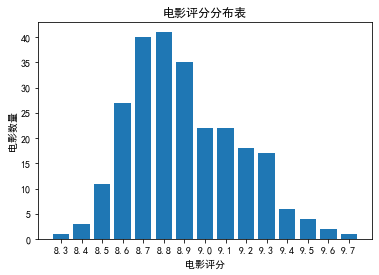

爬取完毕


In [16]:
if __name__ == '__main__':
#调用函数
    main()
    print("爬取完毕")